In [64]:
import vcf
import pandas as pd
import os
from collections import *
import itertools
from tools.fileOps import *

In [100]:
bins = {'A1': 'working/PhaseBarcodesStep/bins/5.bin.txt',
       'A2': 'working/PhaseBarcodesStep/bins/6.bin.txt',
       'B1': 'working/PhaseBarcodesStep/bins/7.bin.txt',
       'B2': 'working/PhaseBarcodesStep/bins/8.bin.txt',
       'C1': 'reassemble_c9_k2/working/PhaseBarcodesStep/bins/0.bin.txt',
       'C2': 'reassemble_c9_k2/working/PhaseBarcodesStep/bins/1.bin.txt'}

bcodes = {b: {x.rstrip() for x in open(p)} for b, p in bins.iteritems()}

In [207]:
vcf_reader = vcf.Reader(open('../outs/phased_variants.vcf.gz'))

In [208]:
vars = list(vcf_reader.fetch('chr1', 145318542, 150302165))

In [209]:
# group by phase set
vars = sorted(vars, key=lambda x: x.samples[0].data.PS)
phase_blocks = {key: list(group) for key, group in itertools.groupby(vars, lambda v: v.samples[0].data.PS)}

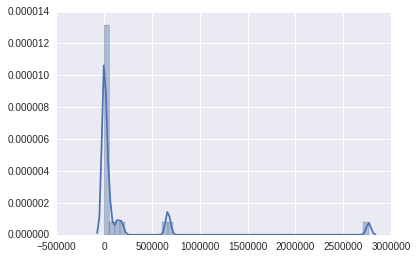

In [67]:
import seaborn as sns
%matplotlib inline

sizes = [x[-1].POS - x[0].POS for x in phase_blocks.itervalues() if len(x) > 1]
sns.distplot(sizes)

In [109]:
# construct a BED of phase blocks
blocks = [['chr1', y[0].POS, y[-1].POS, x] for x, y in phase_blocks.iteritems() if len(y) > 1] 
print_rows('phase_blocks.bed', blocks)

In [94]:
# find the set of barcodes in each block
phased_barcodes = {}
for pos, recs in phase_blocks.iteritems():
    a = set()
    b = set()
    for rec in recs:
        a.update({x.split('_')[0] for x in rec.samples[0].data.BX[0].split(';')})
        b.update({x.split('_')[0] for x in rec.samples[0].data.BX[1].split(';')})
    phased_barcodes[pos] = (a, b)

In [105]:
# for each phase block, find intersection with our sets
associate_with_bcodes = []
for pos, (a, b) in sorted(phased_barcodes.iteritems(), key=lambda x: x[0]):
    for n, s in zip(*[[0, 1], [a, b]]):
        for para, bcode_set in bcodes.iteritems():
            associate_with_bcodes.append([pos, n, para, set.intersection(s, bcode_set)])

In [110]:
# how many?
df_vals = []
for pos, n, para, i in associate_with_bcodes:
    df_vals.append([pos, n, para, len(i)])

df = pd.DataFrame(df_vals, columns=['pos', '10x haplotype', 'phased paralog', 'size of intersection'])

In [114]:
df[df.pos.isin([146127149, 146316718, 149351268])].to_csv('10x_comparison.csv')

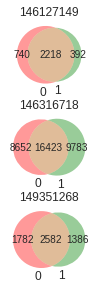

In [135]:
# how big are the overlaps for each anyways?
from matplotlib_venn import *
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 1)
i = 0
for pos, (a, b) in sorted(phased_barcodes.iteritems(), key=lambda x: x[0]):
    if pos in [146127149, 146316718, 149351268]:
        ax = axes[i]
        v = venn2([a, b], set_labels=('0', '1'), ax=ax)
        ax.set_title(pos)
        i += 1
plt.tight_layout()

In [217]:
# try filtering for q70
# find the set of barcodes in each block
phased_barcodes_q70 = {}
for pos, recs in phase_blocks.iteritems():
    a = set()
    b = set()
    for rec in recs:
        avals = rec.samples[0].data.BX[0].split(';')
        avals = [x.split('_') for x in avals]
        for x in avals:
            if any(x >= 70 for x in map(int, x[1:])):
                a.add(x[0])
        bvals = rec.samples[0].data.BX[1].split(';')
        bvals = [x.split('_') for x in bvals]
        for x in bvals:
            if any(x >= 70 for x in map(int, x[1:])):
                b.add(x[0])
    phased_barcodes_q70[pos] = (a, b)

In [218]:
# for each phase block, find intersection with our sets
associate_with_bcodes_q70 = []
for pos, (a, b) in sorted(phased_barcodes_q70.iteritems(), key=lambda x: x[0]):
    for n, s in zip(*[[0, 1], [a, b]]):
        for para, bcode_set in bcodes.iteritems():
            associate_with_bcodes_q70.append([pos, n, para, set.intersection(s, bcode_set)])

# how many?
df_vals_q70 = []
for pos, n, para, i in associate_with_bcodes_q70:
    df_vals_q70.append([pos, n, para, len(i)])

df_q70 = pd.DataFrame(df_vals_q70, columns=['pos', '10x haplotype', 'phased paralog', 'size of intersection'])
#df_60[df_60.pos.isin([146127149, 146316718, 149351268])].to_csv('10x_comparison.csv')
print df_q70[df_q70.pos.isin([146127149, 146316718, 149351268])]

           pos  10x haplotype phased paralog  size of intersection
72   146127149              0             A1                   143
73   146127149              0             A2                   424
74   146127149              0             B1                   207
75   146127149              0             B2                   334
76   146127149              0             C2                     5
77   146127149              0             C1                     5
78   146127149              1             A1                   134
79   146127149              1             A2                   424
80   146127149              1             B1                   205
81   146127149              1             B2                   315
82   146127149              1             C2                     5
83   146127149              1             C1                     0
252  146316718              0             A1                   473
253  146316718              0             A2                  

In [219]:
# try filtering for q70 and passing
# find the set of barcodes in each block
phased_barcodes_q70_pass = {}
for pos, recs in phase_blocks.iteritems():
    a = set()
    b = set()
    for rec in recs:
        if len(rec.FILTER) > 0:
            continue
        avals = rec.samples[0].data.BX[0].split(';')
        avals = [x.split('_') for x in avals]
        for x in avals:
            if any(x >= 70 for x in map(int, x[1:])):
                a.add(x[0])
        bvals = rec.samples[0].data.BX[1].split(';')
        bvals = [x.split('_') for x in bvals]
        for x in bvals:
            if any(x >= 70 for x in map(int, x[1:])):
                b.add(x[0])
    phased_barcodes_q70_pass[pos] = (a, b)

# for each phase block, find intersection with our sets
associate_with_bcodes_q70_pass = []
for pos, (a, b) in sorted(phased_barcodes_q70_pass.iteritems(), key=lambda x: x[0]):
    for n, s in zip(*[[0, 1], [a, b]]):
        for para, bcode_set in bcodes.iteritems():
            associate_with_bcodes_q70_pass.append([pos, n, para, set.intersection(s, bcode_set)])

# how many?
df_vals_q70_pass = []
for pos, n, para, i in associate_with_bcodes_q70_pass:
    df_vals_q70_pass.append([pos, n, para, len(i)])

df_q70_pass = pd.DataFrame(df_vals_q70_pass, columns=['pos', '10x haplotype', 'phased paralog', 'size of intersection'])
#df_60[df_60.pos.isin([146127149, 146316718, 149351268])].to_csv('10x_comparison.csv')
print df_q70_pass[df_q70_pass.pos.isin([146127149, 146316718, 149351268])]

           pos  10x haplotype phased paralog  size of intersection
72   146127149              0             A1                   143
73   146127149              0             A2                   416
74   146127149              0             B1                   206
75   146127149              0             B2                   311
76   146127149              0             C2                     3
77   146127149              0             C1                     4
78   146127149              1             A1                   128
79   146127149              1             A2                   419
80   146127149              1             B1                   199
81   146127149              1             B2                   314
82   146127149              1             C2                     5
83   146127149              1             C1                     0
252  146316718              0             A1                   365
253  146316718              0             A2                  